# Identifying Musical Genres From Album Covers
## Introduction
#### Diego Ferreira, Boshen Tan, Jacob Yank


There is perhaps nothing more fundamental to the human experience than music. Its beginnings are a topic of contentious debate, but there is [strong evidence of the existence of music in prehistoric/preliterate cultures](https://en.wikipedia.org/wiki/Prehistoric_music). It has evolved with us as we civilized and has never left our side. 

Yet with the onset of industrialization and the now massive business that is the music industry, it would be naive to understand music exclusively as such. There is so much more that goes into the art than just the song. The phonographic cylinder was the earliest commercial product for recording and reproducing sound. Yet in 1910, they were replaced with the 78-rpm record. For nearly 30 years, these records were packaged in plain white and brown paper covers. It was when [Columbia Records hired Alex Steinweiss](https://en.wikipedia.org/wiki/Album_cover#Early_history) as its first art director in 1938 that the tide began to change. He is credited with inventing the concept of album covers and cover art, and very quickly other record companies began to follow suit. 

Since then, all commercial music has been identified with an album cover. They have offered artists and record companies alike the opportunity to express themselves through a visual medium, not being bound to the realm of sound. 

We have all grown up and lived our lives in a world where the cover and music coexist. Their relationship is unique, and not bidirectional. The cover is a product of the music. However, the music can, and as mentioned earlier, has existed, without the cover. When we discuss the genre, we are evaluating the song. Yet as humans, and listeners of music, we have an intuition of what an album will sound like by simply looking at the cover. Without hearing a single song, we can confidently and accurately predict what it will sound like. This tells us there is a pattern. Be it through choice of font, design, or themes, the artist can communicate what their music will sound like through an image.

For example, Metal albums can be identified by sharp fonts, the inclusion of monsters and frightening creatures, and the themes of death and violence.

|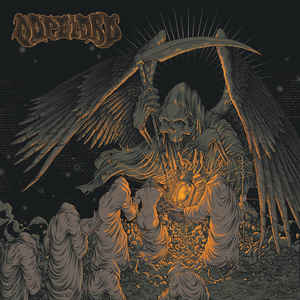|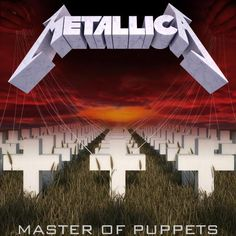 | 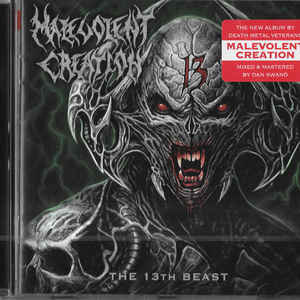|
|-|-|-|

## Motivation

It was this question, of whether machines can learn to perform this same inferential task that we humans do when first seeing an album cover, without ever being exposed to the music lying underneath, that piqued our curiosity. 

There are, however, useful applications of this type of work beyond the high level “interesting” questions about learning it proposes. This is a form of genre classification, which has many key uses in billion dollar companies like Spotify or Apple’s Music platform. Good genre classification is the backbone of a strong recommendation system, music generation, and even instrument recognition. While not public, it is safe to assume that these platform’s make use of song data when performing classification. We are not claiming an alternative to this approach. Rather, we believe that including cover art as a part of this classification task offers a more holistic approach. Simply put, sound data is much more difficult to work with than images, in large part because of how difficult it is to transform it into tabular data. An effect of this is that the tools for learning from audio are not as developed and studied as those for images. There is no one size fits all solution, and thus we look to explore how album art can contribute.


## Dataset Selection

For this project we decided to use the "[20K Album Covers Within 20 Genres](https://www.kaggle.com/datasets/michaeljkerr/20k-album-covers-within-20-genres)" dataset that we found on Kaggle.

We chose this dataset because each genre contained 1000 images and it also contained a good variety of genres to select from.

In [2]:
# Import all the libraries we will be using to create our model
import os
import PIL
import PIL.Image
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
import pathlib
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import random
import shutil

We will be using the python package [pathlib](https://docs.python.org/3/library/pathlib.html) in order to access the album cover files and directories from our local disk. Below we have listed the 20 genres which encompass the GAID dataset.

In [2]:
# Here we are looping thorough the files inside GAID and adding their names to a list. 
# Which we then use when creating our datafram for better visualiztion

data_dir = pathlib.Path('GAID')
names = []
[names.append(x.name) for x in data_dir.iterdir() if x.is_dir()]
df = pd.DataFrame(names)
df.columns =['Genre']
df

,Genre
0,Blues
1,Classical
2,Country
3,DeathMetal
4,DoomMetal
5,DrumNBass
6,Electronic
7,Folk
8,Grime
9,HeavyMetal


After looping through the directory we can see that the dataset contains some subgenres. To test the overall accuracy of our model we will first test it on the complete dataset. If we notice that the accuracy is bad we will simplify the dataset as follows: 
We decided to group the subgenres as follows:
1. Doom Metal, Heavy Metal and Death Metal &rarr; Metal
2. Electronic, LoFi &rarr; Electronic
3. DrumNBass, Techno &rarr; Dance Music
4. Rock, Psychedelic Rock, Punk &rarr; Rock
5. Hip Hop, Grime &rarr; Hip Hop

We decided to duplicate the file on our computer and group subgenres together. These files are now stored in the GAIDSimple folder. To verify that everything is in its proper location we check the folder names inside GAIDSimple.

In [3]:
# Repeat the same as above to check if the folders are the ones we want.

data_dir = pathlib.Path('GAIDSimple')
names = []
[names.append(x.name) for x in data_dir.iterdir() if x.is_dir()]
df = pd.DataFrame(names)
df.columns =['Genre']
df

,Genre
0,Blues
1,Classical
2,Country
3,Dance
4,Electronic
5,Folk
6,HipHop
7,Jazz
8,Metal
9,Pop


Now we can see that in the directory that we will be working with only contains 13 genres and is simpler than the original model.

# Convolutional Neural Network (CNN)

Given that our data is a set of images, the best approach to learning from them is to use Convolutional Neural Networks (CNNs). Why? Put simply, their built-in convolutional layers reduce the high dimensionality of images without losing its information. When we see an image, we automatically divide it into many small sub-images and analyze them one by one. By assembling these sub-images, we process and interpret the image. This is the approach mimicked by the CNN. 

A CNN is made up of 3 parts, the convolutional layers, the pooling layers, and the fully-connected layers. In the convolutional layers, we define a filter that determines the size of the pieces of the image we want to look at, as well as a step length that determines how close these partial images are to one another. The pooling layer is the same as the convolutional layer from a computational point of view, but differs in a significant way. It takes the output of a convolutional layer as input, and from there finds either the maximum or average of all those input matrices. This works to filter out the noise (features that are not helpful to our classification), and amplify the most important features. Finally, the fully connected layer is just a regular neural network, operating on our images with reduced dimensionality. This article does a good job of [introducing CNNs](https://towardsdatascience.com/using-convolutional-neural-network-for-image-classification-5997bfd0ede4#:~:text=The%20Convolutional%20Neural%20Network%20(CNN,suited%20for%20this%20use%20case.).



We now move on to splitting the dataset into the training set and the validation set. We will be using the common 80/20 split. For those curious as to why this is seemingly the default split when working with a learning model, we recommend reading about the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle).

We will be using the [TensorFlow](https://www.tensorflow.org/) library for our model construction. TensorFlow was developed by the Google brain team and is one of the most popular libraries used in Machine Learning, along with PyTorch. 

Here we create the training dataset by calling tf.keras.utils.image_dataset_from_directory. We specify the directory that we are working with, the validation split (how much data goes into the training and validation sets), the seed (to prevent sets from having some of the same images), the image size, the batch size and finally the color mode.

We decided to set the images to grayscale and reduce their resolution so that it would be easier to run the code on our computers. 

In [4]:
# Specify the path
data_dir = pathlib.Path('GAID')

# Set the batch size and dimensions of our image. We decided to reduce the resolution of the image to use less memory and
# run faster
batch_size = 32
img_height = 140
img_width = 140


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size, color_mode = "grayscale")

Found 20000 files belonging to 20 classes.
Using 16000 files for training.


In [5]:
# Repeat the same as above but now for the validation set. 
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,  color_mode = "grayscale")

Found 20000 files belonging to 20 classes.
Using 4000 files for validation.


To get an idea of what our CNN will be "seeing" we print out some of the images along with their associated label.

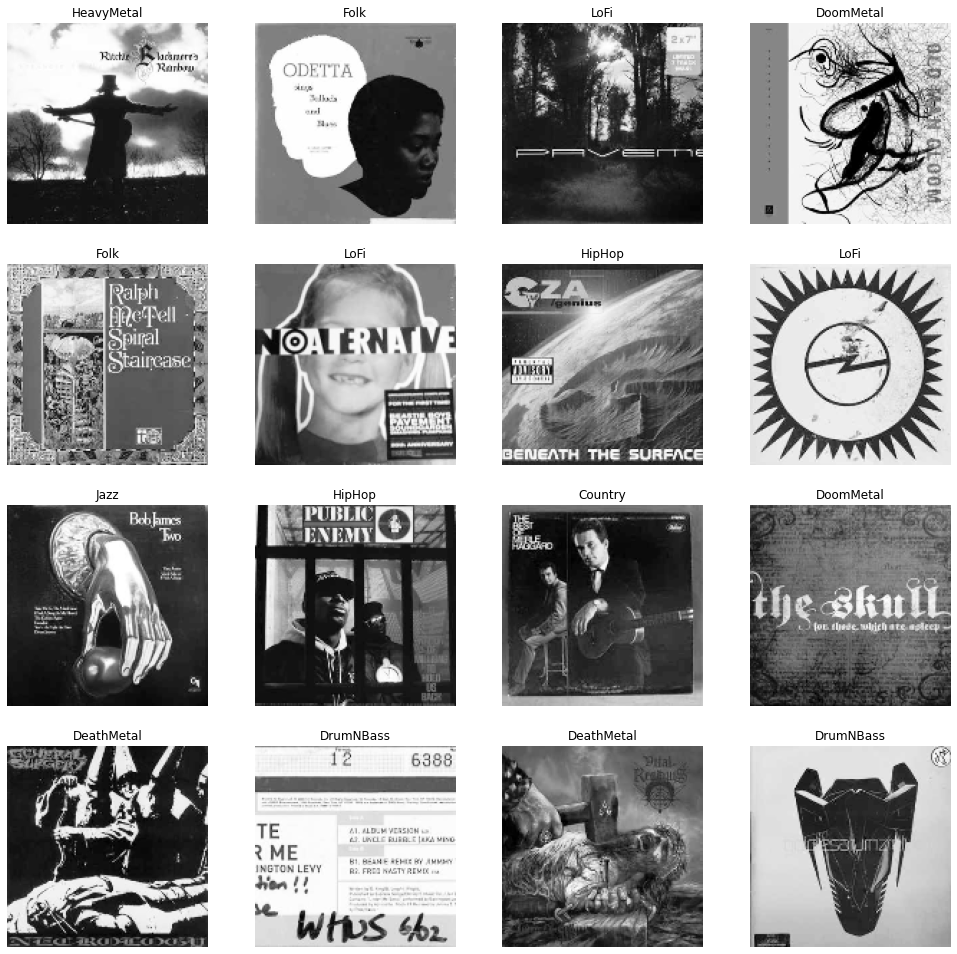

In [6]:
# We loop through a small subset of the dataset and print the images and corresponding labels using the 
# matplotlib.pyplot library.

class_names = train_ds.class_names

plt.figure(figsize=(17, 17))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.imshow(images[i], cmap='Greys_r')
        plt.axis("off")

As it was mentioned above, we used tensorflow to create our CNN. We decided to use the same model that was described in one of their [image classification tutorials](https://www.tensorflow.org/tutorials/images/classification) to see how well it would perform. Their model has 3 layers and uses the [ReLu activation function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/), which basically means it outputs the input if the input is positive and zero otherwise. This is good because it avoids some [issues with vanishing gradients](https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484) that some other activation functions may experience.

In [7]:
# Calling autotune allows tensorflow to optimize the performance of the model
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Now onto our model. We start by specifying the number of classes, which in this first run will be 20. We then create our model, with 3 convolutional layers and a max pooling layer after each. At the very end, we have a fully connected layer.

In [8]:
# Specify the number of classes for our model. 
num_classes = 20

# Here we specify how the model will work.
full_gaid_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Next we compile the model and specify which optimizer and loss function will be used. In this case we used the state of the art [Adam optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) and a [crossentropy loss function](https://machinelearningmastery.com/cross-entropy-for-machine-learning/).

In [9]:
# Compile the model. Specify optimizer, loss and metrics 
# (how is the model being evaluated, in this case its by its accuracy)
full_gaid_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

We decided to only run the model 5 times to speed up the process. With 5 epochs we can also get a good graph to see what the accuracy trend is over time and if the model is overfitting or underfitting. 

In [10]:
epo = 5
full_gaid_model_history = full_gaid_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epo
)

Epoch 1/5
500/500 [==============================] - 125s 248ms/step - loss: 4.5054 - accuracy: 0.0608 - val_loss: 2.9760 - val_accuracy: 0.0542
Epoch 2/5
500/500 [==============================] - 112s 224ms/step - loss: 2.8799 - accuracy: 0.1028 - val_loss: 3.0286 - val_accuracy: 0.0695
Epoch 3/5
500/500 [==============================] - 112s 223ms/step - loss: 2.6827 - accuracy: 0.1714 - val_loss: 3.1299 - val_accuracy: 0.0637
Epoch 4/5
500/500 [==============================] - 112s 223ms/step - loss: 2.5693 - accuracy: 0.2124 - val_loss: 3.1898 - val_accuracy: 0.0672
Epoch 5/5
500/500 [==============================] - 111s 222ms/step - loss: 2.4665 - accuracy: 0.2490 - val_loss: 3.2969 - val_accuracy: 0.0655


We now plot the training accuracy vs validation accuracy as well as the training loss vs validation loss. Both of which will be measured accross the number of epochs.

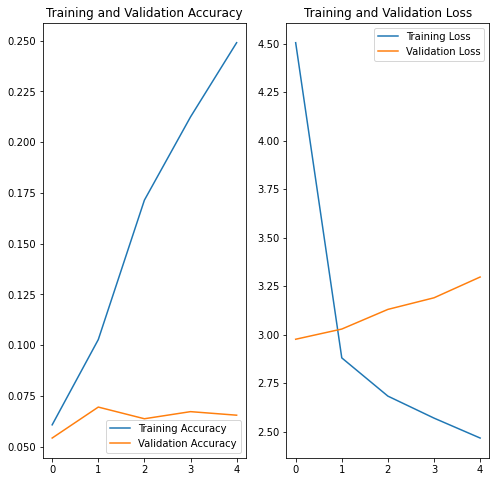

In [11]:
#  Access the history of the model to get the accuracy after each epoch. 
accuracy = full_gaid_model_history.history['accuracy']
val_accuracy = full_gaid_model_history.history['val_accuracy']

loss = full_gaid_model_history.history['loss']
val_loss = full_gaid_model_history.history['val_loss']

epochs_range = range(epo)

# Use matplotlib to plot the accuracy over the number of epochs. 
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Based on the model we created we can see that our accuracy is very low. We ran 5 epochs and achieved a max training accuracy of 23.3% however our validation accuracy has not improved at all and has remained at about 7% the entire time. From these values we can see that the model is clearly underfitting, a nice way of of saaying that it hasn't learned. Considering there are 20 classes by random guessing the genres we would expet an accuracy of 1/20 = 5%. So our model is performing about the same as random guessing. 

We decided to try it again on the simplified dataset that only contains 13 classes (No subgenres). 

Below we repeat the exact same process as above but change the directory GAIDSimple, which is the one that grouped similiar subgenres into the same genre. The number or layers, optimizer, loss and other parameters were kept the same. Comments inside the code were ommited because the code is the same and to save space.

In [12]:
data_dir = pathlib.Path('GAIDSimple')

batch_size = 32
img_height = 140
img_width = 140
 
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size, color_mode = "grayscale")

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,  color_mode = "grayscale")

# Specify the number of classes for our model. In this case since we are using the simplified model we have 13 classes. 
num_classes = 13

simple_gaid_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

simple_gaid_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

simple_gaid_model_history = simple_gaid_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epo
)

Found 19914 files belonging to 13 classes.
Using 15932 files for training.
Found 19914 files belonging to 13 classes.
Using 3982 files for validation.
Epoch 1/5
498/498 [==============================] - 123s 244ms/step - loss: 3.7265 - accuracy: 0.1586 - val_loss: 2.4221 - val_accuracy: 0.1698
Epoch 2/5
498/498 [==============================] - 120s 241ms/step - loss: 2.3575 - accuracy: 0.1966 - val_loss: 2.4934 - val_accuracy: 0.1725
Epoch 3/5
498/498 [==============================] - 122s 245ms/step - loss: 2.1635 - accuracy: 0.2697 - val_loss: 2.6754 - val_accuracy: 0.1690
Epoch 4/5
498/498 [==============================] - 127s 254ms/step - loss: 1.9110 - accuracy: 0.3607 - val_loss: 3.0515 - val_accuracy: 0.1554
Epoch 5/5
498/498 [==============================] - 124s 249ms/step - loss: 1.7096 - accuracy: 0.4369 - val_loss: 3.5330 - val_accuracy: 0.1602


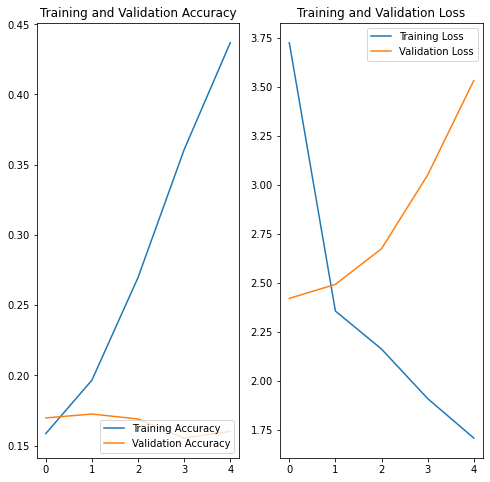

In [13]:
accuracy = simple_gaid_model_history.history['accuracy']
val_accuracy = simple_gaid_model_history.history['val_accuracy']

loss = simple_gaid_model_history.history['loss']
val_loss = simple_gaid_model_history.history['val_loss']

epochs_range = range(epo)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the graphs above we can see that the model is performing better. Its training accuracy is up to about 45% but its testing accuracy hovers at about 16%. Considering there are 13 classes on the dataset (some bigger than others) random guessing would get about 1/13 = 7.69%. So the model performs better than random guessing but it is not as good as we would want. However, we can see that the model is still not learning well enough to be able to generalize. 

To attempt to solve the problem we will simplify our CNN. Instead of doing 3 convolution layers we will do only 1. Deeper Neural Networks are better capturing complex patterns but lets see if a simpler model will be able to generalize better. 

For this next part we will use the GAID simple dataset but only use 1 convolutional layer. 

In [4]:
data_dir = pathlib.Path('GAIDSimple')

batch_size = 32
img_height = 140
img_width = 140
 
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size, color_mode = "grayscale")

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,  color_mode = "grayscale")

# Specify the number of classes for our model. In this case since we are using the simplified model we have 13 classes. 
num_classes = 13

simple_gaid_simple_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

epo = 5

simple_gaid_simple_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

simple_gaid_simple_model_history = simple_gaid_simple_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epo
)

Found 19914 files belonging to 13 classes.
Using 15932 files for training.
Found 19914 files belonging to 13 classes.
Using 3982 files for validation.
Epoch 1/5
498/498 [==============================] - 239s 479ms/step - loss: 142.2177 - accuracy: 0.1421 - val_loss: 4.0532 - val_accuracy: 0.1748
Epoch 2/5
498/498 [==============================] - 226s 453ms/step - loss: 1.8947 - accuracy: 0.4635 - val_loss: 3.7795 - val_accuracy: 0.1813
Epoch 3/5
498/498 [==============================] - 234s 469ms/step - loss: 1.1819 - accuracy: 0.7034 - val_loss: 4.3298 - val_accuracy: 0.1969
Epoch 4/5
498/498 [==============================] - 242s 486ms/step - loss: 1.0400 - accuracy: 0.7884 - val_loss: 4.8657 - val_accuracy: 0.1984
Epoch 5/5
498/498 [==============================] - 237s 475ms/step - loss: 1.0838 - accuracy: 0.7893 - val_loss: 5.5120 - val_accuracy: 0.1906


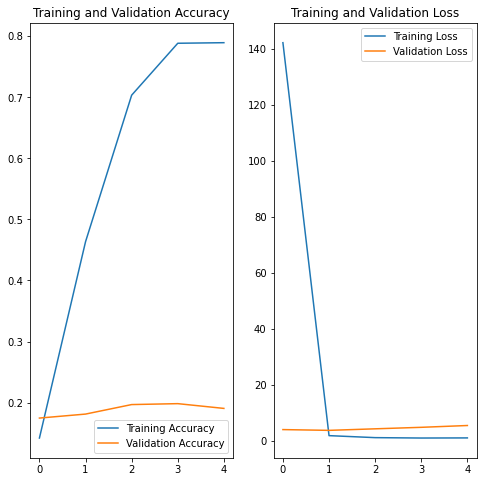

In [5]:
accuracy = simple_gaid_simple_model_history.history['accuracy']
val_accuracy = simple_gaid_simple_model_history.history['val_accuracy']

loss = simple_gaid_simple_model_history.history['loss']
val_loss = simple_gaid_simple_model_history.history['val_loss']

epochs_range = range(epo)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the graphs above we can see that while the single convolutional layered model has significantly higher training accuracy compared to the previous model (~80% vs ~45%), the validation accuracy is only marginally better. This model is likely too simple and is overfitting the training data. The ~60% difference between training and validation accuracy is alarming, but this speaks more to difficulty of the problem than anything.

For the next step, we want to see how a well trained model performs with the same dataset. For this section we will use VGG16, a pretrained model that won 1st and 2nd place at the 2014 [ImageNet Large Scale Visual Recognition Challenge](https://image-net.org/challenges/LSVRC/).

## VGG16

VGG16 is a very deep CNN that contains 13 convolutional layers, 5 Max Pooling layers and 3 Dense layers of those layers 16 of them are weighted. The main difference between VGG16 and any other CNN is its architecture and that it can be used as a pre-trained image model, meaning we can start the model with the weights that were learned when training on a large dataset. To learn more about VGG16 we recomend reading a [brief introduction and tutorial](https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918) to get an idea of how everything is set up. You can also read [Transfer Learning with VGG16 and Keras](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4) for more information.

For this model we will run 5 epochs using the GAIDSimple dataset, and we would use RGB values instead of grayscale. With this we will compare with the model used in the tensorflow example and also with our simple model. 

For this model we create two folders that contain the training images and the testing images. To do this we use the following code. We again use the 80/20 split.

We only run this code once, running it again will add more images to the files and we will end up with several duplicates (this is why we have commented it).

In [ ]:
"""

original_dir = 'GAIDSimple'
train_dir = 'GAIDSimpleTrain'
test_dir = 'GAIDSimpleTest'

# Set up split ratio. In this case we want 80% of the images to be used for training and 20% to be used for testing. 
split = 0.8

# We iterate over the subfolders and and joinn the paths
for label_folder in os.listdir(original_dir):
    label_folder_path = os.path.join(original_dir, label_folder)
    if os.path.isdir(label_folder_path):
        # Get the list of images
        image_files = os.listdir(label_folder_path)

        # Randomly shuffle them
        random.shuffle(image_files)

        # Find the index where we split. Based on the ratio determined
        split_index = int(split * len(image_files))

        # Move images to training directory
        for image in image_files[:split_index]:
            src = os.path.join(label_folder_path, image)
            dst = os.path.join(train_dir, label_folder, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)

        # Move images to testing directory
        for image in image_files[split_index:]:
            src = os.path.join(label_folder_path, image)
            dst = os.path.join(test_dir, label_folder, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)
            
"""

We start by seperating the training and testing data, resizing the images to 140 by 140, and rescaling the RBG values to make them small.

In [17]:
# Preprocess the data and create data generators
train_data_dir = 'GAIDSimpleTrain'
test_data_dir = 'GAIDSimpleTest'
batch_size = 64

# Rescale RGB values
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Split training and test data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(140, 140),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(140, 140),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

Found 15929 images belonging to 13 classes.
Found 3985 images belonging to 13 classes.


We then set up the VGG16 model with the weights learned from the massive [imagenet](https://www.image-net.org/) dataset. We aslo display the model below.

In [18]:
# Set up VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(140, 140, 3))
base_model.trainable = False 
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140, 140, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 140, 140, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 140, 140, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 70, 70, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 70, 70, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 70, 70, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 35, 35, 128)       0     

We stack 3 layers together, a global pooling layer, and 2 fully connected layers. This creates a VGG16-based model that takes an input image, performs convolutional operations and pooling using the pre-trained VGG16 architecture, applies global average pooling to reduce the spatial dimensions, passes the features through a dense layer for further feature learning, and finally produces class predictions using the softmax activation function

In [19]:
avg = tf.keras.layers.GlobalAveragePooling2D()
dense = Dense(512, activation='relu')
predictions = Dense(13, activation='softmax')
vgg16_model = tf.keras.Sequential([
    base_model,
    avg,
    dense,
    predictions
])
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Train the model
vgg16_model_history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epo,
    validation_data=test_generator,
    validation_steps=len(test_generator))

Epoch 1/5
249/249 [==============================] - 975s 4s/step - loss: 2.3016 - accuracy: 0.2348 - val_loss: 2.2466 - val_accuracy: 0.2645
Epoch 2/5
249/249 [==============================] - 996s 4s/step - loss: 2.1847 - accuracy: 0.2762 - val_loss: 2.2519 - val_accuracy: 0.2590
Epoch 3/5
249/249 [==============================] - 972s 4s/step - loss: 2.1389 - accuracy: 0.2930 - val_loss: 2.1697 - val_accuracy: 0.2838
Epoch 4/5
249/249 [==============================] - 969s 4s/step - loss: 2.1032 - accuracy: 0.3052 - val_loss: 2.1882 - val_accuracy: 0.2775
Epoch 5/5
249/249 [==============================] - 1179s 5s/step - loss: 2.0695 - accuracy: 0.3163 - val_loss: 2.1750 - val_accuracy: 0.2876


Below we plot the training/validation accuracies as well as the training/validation loss functions for VGG.

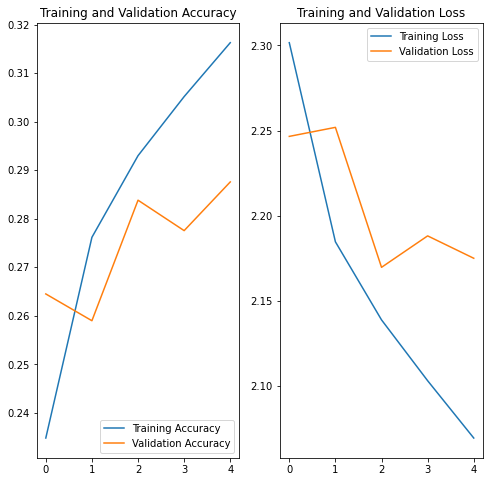

In [21]:
accuracy = vgg16_model_history.history['accuracy']
val_accuracy = vgg16_model_history.history['val_accuracy']

loss = vgg16_model_history.history['loss']
val_loss = vgg16_model_history.history['val_loss']

epochs_range = range(epo)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Based on the graph above we can see that while the training accuracy of the VGG16 model was lower than the training accuracy of our simple CNN models its testing accuracy is more 1.5 times better. This is what we would expect, and is a positive result. VGG has the advantage of many more convolutional layers, pretrained weights that were successful on an enormous image data set, and color information.

One actionable takeaway that fits our intuition is the value of color data. Color does not exist in a vaccum, it adds contrast and shape to the images that are lost when using grayscale. The heavy oranges  and reds of Metal covers give them so much of their flavor, while the deep and soothing blues and purples of jazz and soul are characteristic of their slower and lighter style. 

We cannot expect to reach fantastic results just by using someone else's well trained model. Instead, we can learn from what works within it's architecture and what doesn't.

 ## Conclusion

### Is Album Cover Classifaction Achiveable?

From all the testing that was done above, we have no shame in saying that classifying genres based on album covers is a hard problem. As mentioned in our introduction, we are asking a machine to fill a void with a very limited set of tools. Genre is defined by the music, not the album cover. Different artists can have incredible different album covers and still belong to the same genre. Below we have two of the top selling hip-hop albums from last year(2022), as an example.

This demonstrates how the artist communicates their music through their album cover. While both are of the same genre, they don't sound the same. They don't have the same feel. It makes sense that their visual depiction, when left up to the artist, is different.

This challenge is reflected in our models performance. Not even VGG16, an incredible achievement in image recognition, was able to be quickly modified to fit our use case. 

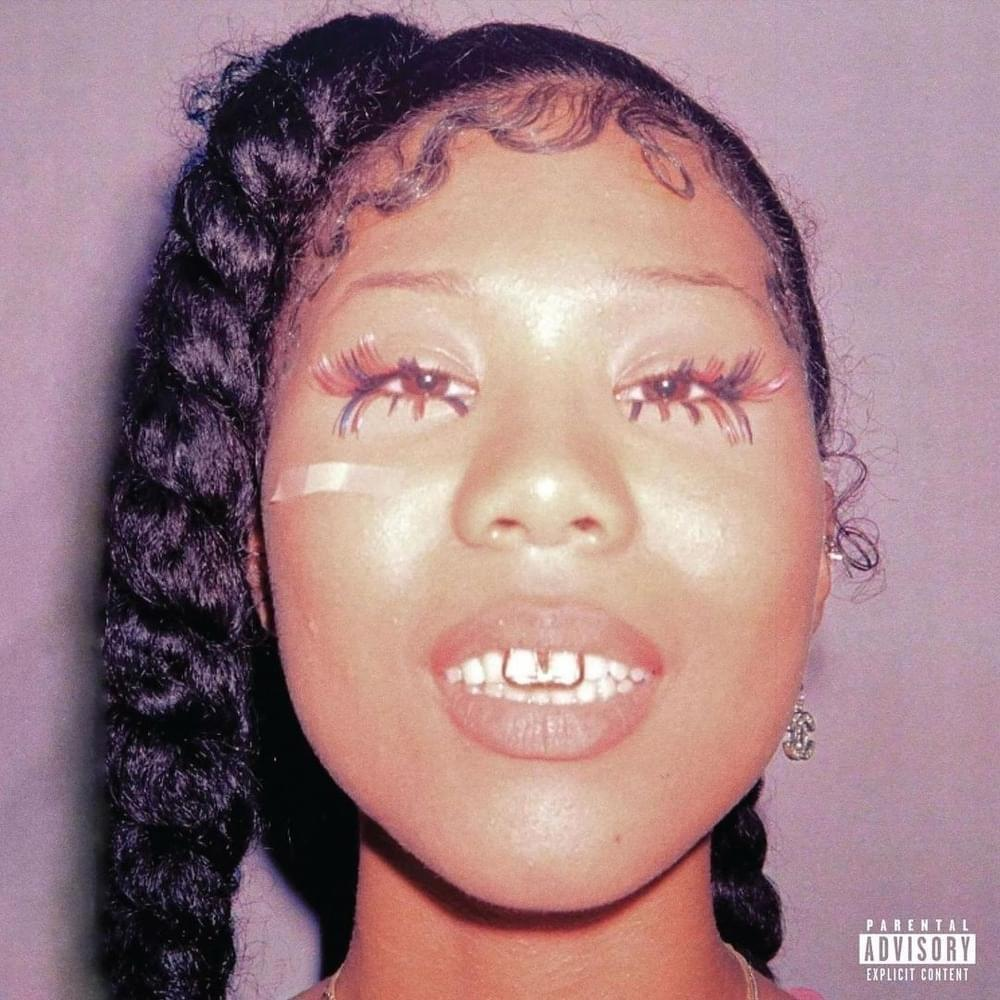

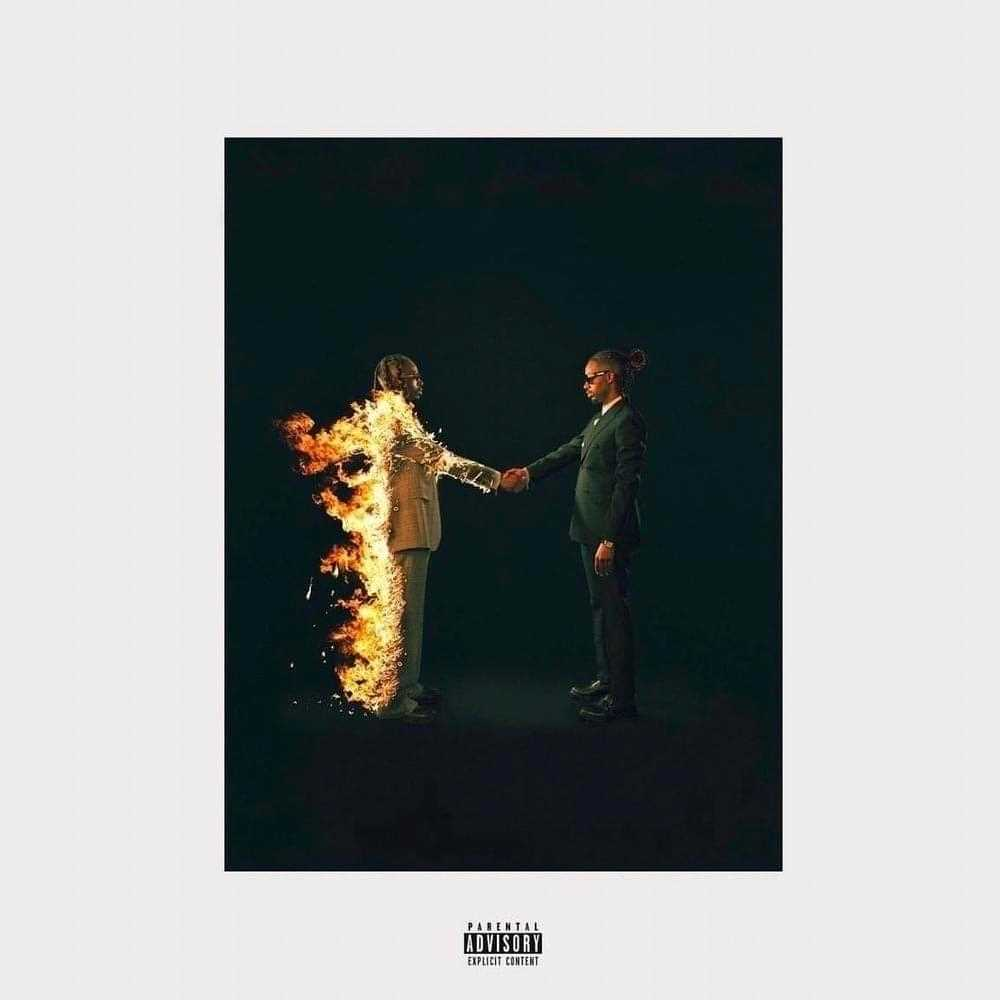

### Improvements

There are two immediate improvements that could be made. First, we would want a better dataset. We noticed that a few images were duplicated, were poor quality, included stickers that were not in the original album covers, and in our opinion, occasionally misclassified. A better dataset would provide more consistent and reliable results. Second, we would want to create a more complex model but we would need better computers to do this. We tried using UMIACS but were restricted when it came to the use of GPUs. Which resulted in us relying on our computers, which significantly limited the number of epochs we could run. With a strong dataset and stronger computational tools, there is hope.